In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# 前処理

In [73]:
#データセットの読み込み
TRAIN_DATA_PATH: str = "dataset/train_Mod.csv"
TEST_DATA_PATH: str = "dataset/test.csv"
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

train_data.head(5)

,id,knee_depth,hip_depth,misalignment,width_of_hand,jump_height,personal_id
0,0,4.114675,20.081082,13.244238,-14.312221,44.388231,A
1,1,2.194313,16.056999,3.360566,-13.784517,45.885170,A
2,2,6.526472,15.633804,3.355818,-0.642056,41.962244,A
3,3,2.307960,17.281763,13.097795,-6.454952,45.614645,A
4,4,3.076618,16.892115,10.723250,-6.547873,44.228786,A


In [74]:
#欠損値の確認
train_data.isnull().sum()

id               0
knee_depth       2
hip_depth        4
misalignment     0
width_of_hand    0
jump_height      0
personal_id      0
dtype: int64

In [75]:
#欠損値の補完（とりあえず平均値で）
train_data["knee_depth"] = train_data["knee_depth"].fillna(train_data["knee_depth"].mean())
train_data["hip_depth"] = train_data["hip_depth"].fillna(train_data["hip_depth"].mean())

#idはいらないので削除
train_data = train_data.drop("id", axis=1)
test_data = test_data.drop("id", axis=1)
train_data.isnull().sum()

knee_depth       0
hip_depth        0
misalignment     0
width_of_hand    0
jump_height      0
personal_id      0
dtype: int64

(array([110.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 110.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 132.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  80.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         80.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.

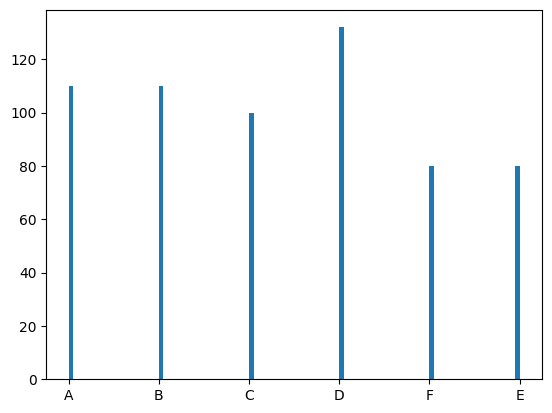

In [76]:
#学習データの偏りを確認する
#出力のpersonal_idをmatplotlibで可視化
plt.hist(train_data["personal_id"], bins=100)

In [77]:
#学習データを訓練用、検証用に分割
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=0)
X_train = train_data.drop("personal_id", axis=1)
y_train = train_data["personal_id"]
X_valid = valid_data.drop("personal_id", axis=1)
y_valid = valid_data["personal_id"]

# ロジスティック回帰による検証

## まずは素で学習させた場合

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

#ハイパーパラメータの初期設定
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}
#評価指標はaccuracy
model = GridSearchCV(LogisticRegression(), params, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train, y_train)

#最適なパラメータを表示
print("the best param is : ", model.best_params_)
print("the best score is : ", model.best_score_)

#検証データで評価
y_pred = model.predict(X_valid)
print("accuracy : ", accuracy_score(y_valid, y_pred))


the best param is :  {'C': 0.1, 'solver': 'newton-cg'}
the best score is :  0.6830212497370083
accuracy :  0.7560975609756098


In [79]:
#前処理として,標準化してみる
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # ステップ1: 標準化
    ('classifier', LogisticRegression(multi_class='multinomial'))  # ステップ2: ロジスティック回帰
])

#ハイパーパラメータの初期設定
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}
#評価指標はaccuracy
model = GridSearchCV(LogisticRegression(), params, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train, y_train)

#最適なパラメータを表示
print("the best param is : ", model.best_params_)
print("the best score is : ", model.best_score_)

#検証データで評価
y_pred = model.predict(X_valid)
print("valid accuracy_score : ", accuracy_score(y_valid, y_pred))


the best param is :  {'C': 0.1, 'solver': 'newton-cg'}
the best score is :  0.6830212497370083
valid accuracy_score :  0.7560975609756098


# 決定木

In [80]:
#単純な決定木
from sklearn.tree import DecisionTreeClassifier

#ハイパーパラメータの初期設定
param = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()), #NOTE:標準化したら少し精度が上がった0.73 -> 0.74
    ('classifier', DecisionTreeClassifier()) 
])

model = GridSearchCV(pipeline, param, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train, y_train)

#最適なパラメータを表示
print("the best param is : ", model.best_params_)
print("the best score is : ", model.best_score_)
#検証データで評価
y_pred = model.predict(X_valid)
print("valid accuracy_score : ", accuracy_score(y_valid, y_pred))

the best param is :  {'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__splitter': 'best'}
the best score is :  0.7443088575636441
valid accuracy_score :  0.7317073170731707


## XGBoost

In [81]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

param = {
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__min_child_weight': [1, 2, 3],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
}

pipeline = Pipeline([
    ('classifier', XGBClassifier(eval_metric='mlogloss'))  # ステップ3: XGBoost
])

#yのラベリング
train_y = train_data["personal_id"]
valid_y = valid_data["personal_id"]
# LabelEncoderのインスタンスを作成
label_encoder = LabelEncoder()
# クラスラベルを数値に変換
y_train_encoded = label_encoder.fit_transform(train_y)
y_valid_encoded = label_encoder.fit_transform(valid_y)


model = GridSearchCV(pipeline, param, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train, y_train_encoded)

#最適なパラメータを表示
print("the best param is : ", model.best_params_)
print("the best score is : ", model.best_score_)
#検証データで評価
y_pred = model.predict(X_valid)
print("valid accuracy_score : ", accuracy_score(y_valid_encoded, y_pred))

KeyboardInterrupt: 

In [ ]:
#標準化を挟んでみる
pipeline = Pipeline([
    ('scaler', StandardScaler()), #NOTE:
    ('classifier', XGBClassifier(eval_metric='mlogloss'))
])

model = GridSearchCV(pipeline, param, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train, y_train_encoded)

#最適なパラメータを表示
print("the best param is : ", model.best_params_)
print("the best score is : ", model.best_score_)
#検証データで評価
y_pred = model.predict(X_valid)
print("valid accuracy_score : ", accuracy_score(y_valid_encoded, y_pred))

the best param is :  {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
the best score is :  0.7892909741216074
valid accuracy_score :  0.8048780487804879
